In [1]:
import shutil
import os
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf
import glob
import os
from PIL import Image
from PIL import ImageFilter
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import scikitplot as skplt
import matplotlib.pyplot as plt
from tensorflow import keras

from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.applications.vgg19 import VGG19
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score
#np.random.seed(123)
import itertools

In [2]:
model = Sequential()
# Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(50,50, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  

# Add 2 final dense layers to add a classifier to the convolutional base
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print(model.summary())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,305 (368.38 KB)

 Trainable params: 94,305 (368.38 KB)

 Non-trainable params: 0 (0.00 B)

None


In [5]:

infected_path = "/Users/fadiabaissi/Downloads/cell_images/Parasitized/"
uninfected_path = "/Users/fadiabaissi/Downloads/cell_images/Uninfected/"
infected_files = os.listdir(infected_path)
uninfected_files = os.listdir(uninfected_path)

# Define functions for data preprocessing
def preprocess_data(file_list, label):
    data = []
    labels = []
    for file in file_list:
        try:
            image = tf.keras.preprocessing.image.load_img(file, target_size=(50, 50))
            image_array = tf.keras.preprocessing.image.img_to_array(image)
            data.append(image_array)
            labels.append(label)
        except Exception as e:
            print(f"Error processing {file}: {e}")
    return data, labels

# Preprocess infected and uninfected data
infected_data, infected_labels = preprocess_data([os.path.join(infected_path, f) for f in infected_files], 1)
uninfected_data, uninfected_labels = preprocess_data([os.path.join(uninfected_path, f) for f in uninfected_files], 0)

# Combine data and labels
data = np.array(infected_data + uninfected_data)
labels = np.array(infected_labels + uninfected_labels)
print(len(data))

kFold=KFold(n_splits=5,shuffle=True)
results=[]
for train_index,test_index in kFold.split(data):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)
    
    X_train, X_test, y_train, y_test = data[train_index], data[test_index], labels[train_index], labels[test_index]
    result = model.fit(
        X_train,y_train,
        epochs=100, # num of epochs will dictate speed of model 
        validation_data=(X_test,y_test),
        )
    results.append(result)
    """X_train.append(data[train_index])
    X_test.append(data[test_index])
    y_train.append(labels[train_index])
    y_test.append(labels[test_index])"""

"""for res in results:
    print(res.history.values())"""


Error processing /Users/fadiabaissi/Downloads/cell_images/Parasitized/Thumbs.db: cannot identify image file <_io.BytesIO object at 0x1148ca700>
Error processing /Users/fadiabaissi/Downloads/cell_images/Parasitized/.DS_Store: cannot identify image file <_io.BytesIO object at 0x1148ca700>
Error processing /Users/fadiabaissi/Downloads/cell_images/Uninfected/Thumbs.db: cannot identify image file <_io.BytesIO object at 0x308b11620>
Error processing /Users/fadiabaissi/Downloads/cell_images/Uninfected/.DS_Store: cannot identify image file <_io.BytesIO object at 0x1148ca700>
27558
Train Index:  [    0     1     2 ... 27554 27555 27557] 

Test Index:  [    5     8    12 ... 27544 27550 27556]
Epoch 1/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.9093 - loss: 0.2627 - val_accuracy: 0.9410 - val_loss: 0.1881
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.9345 - loss: 0.2104 - val_accuracy: 0.9381 - val_loss: 0.2304
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 22s 

'for res in results:\n    print(res.history.values())'

In [7]:
i = 0
for res in results:
    print("===== Iteration", i, ": =====")
    print("Accuracy:", format(res.history['accuracy'][-1], ".2%"))
    print("Loss:", format(res.history['loss'][-1], ".2%"))
    i += 1

===== Iteration 0 : =====
Accuracy: 96.54%
Loss: 13.33%
===== Iteration 1 : =====
Accuracy: 94.66%
Loss: 24.26%
===== Iteration 2 : =====
Accuracy: 91.54%
Loss: 34.48%
===== Iteration 3 : =====
Accuracy: 85.43%
Loss: 54.59%
===== Iteration 4 : =====
Accuracy: 83.00%
Loss: 70.64%


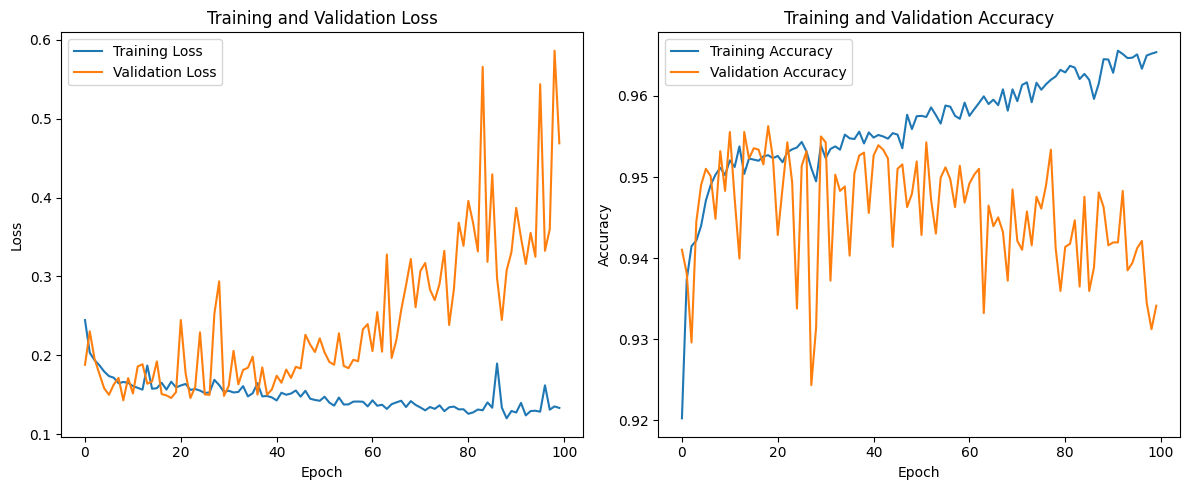

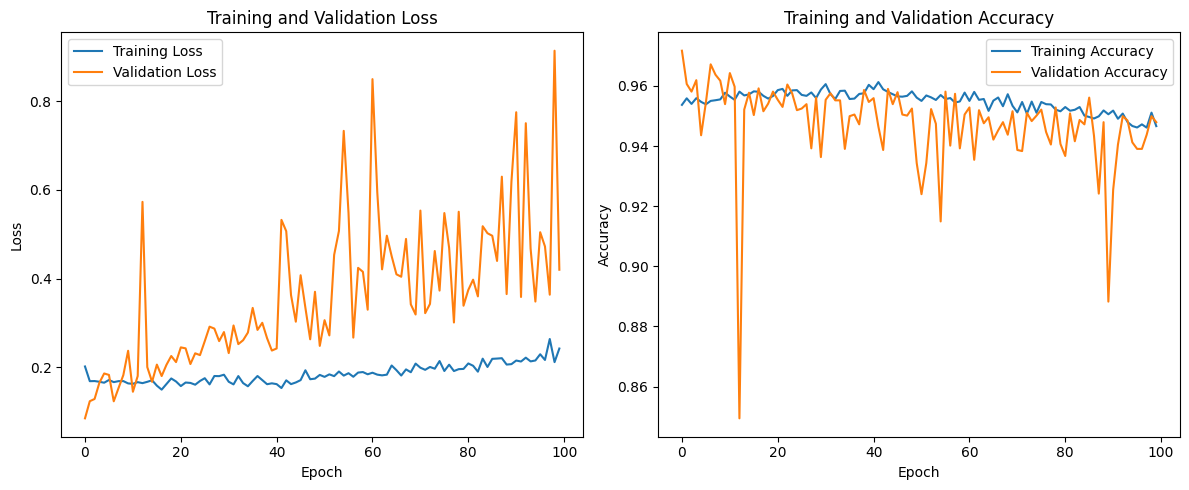

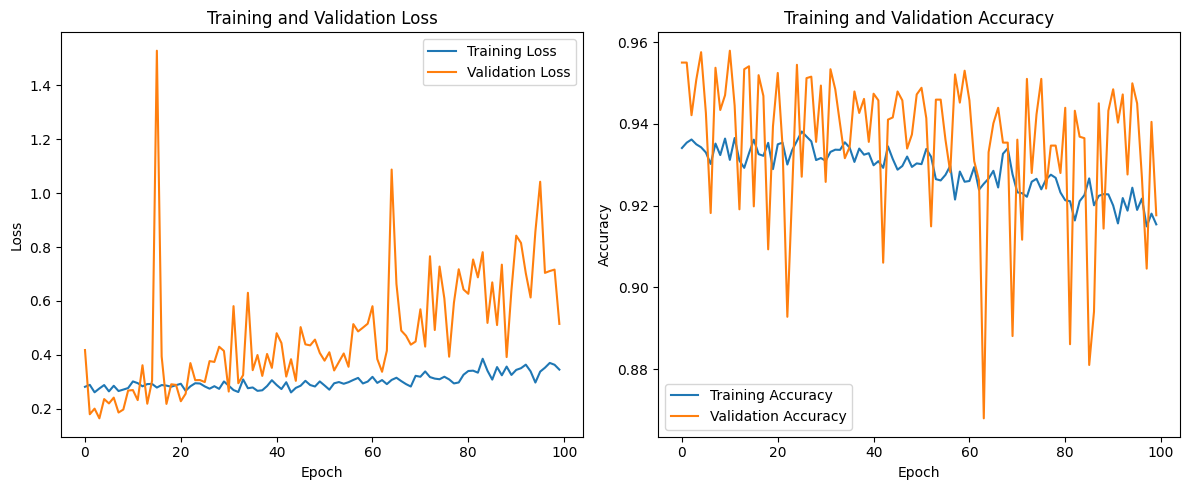

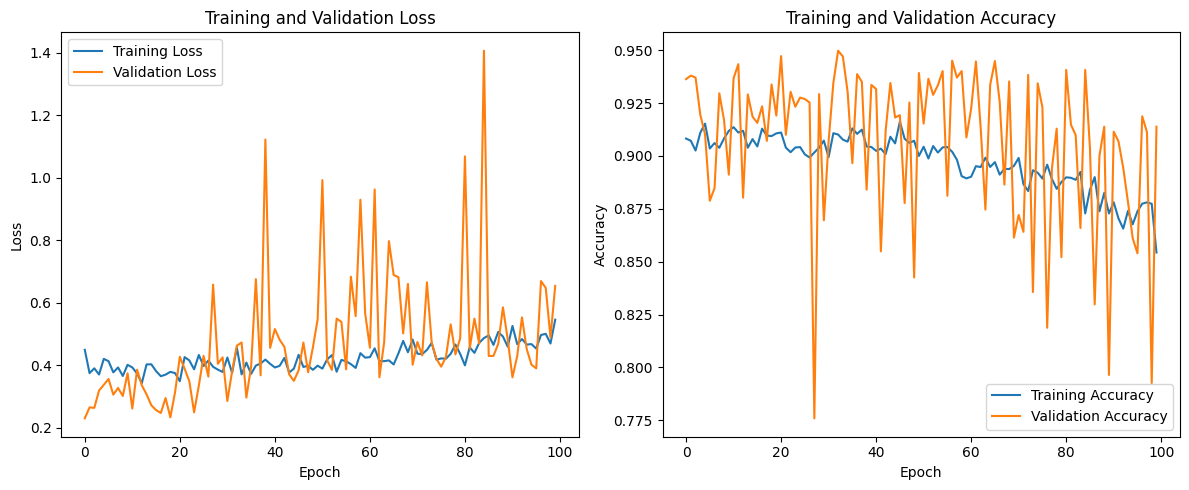

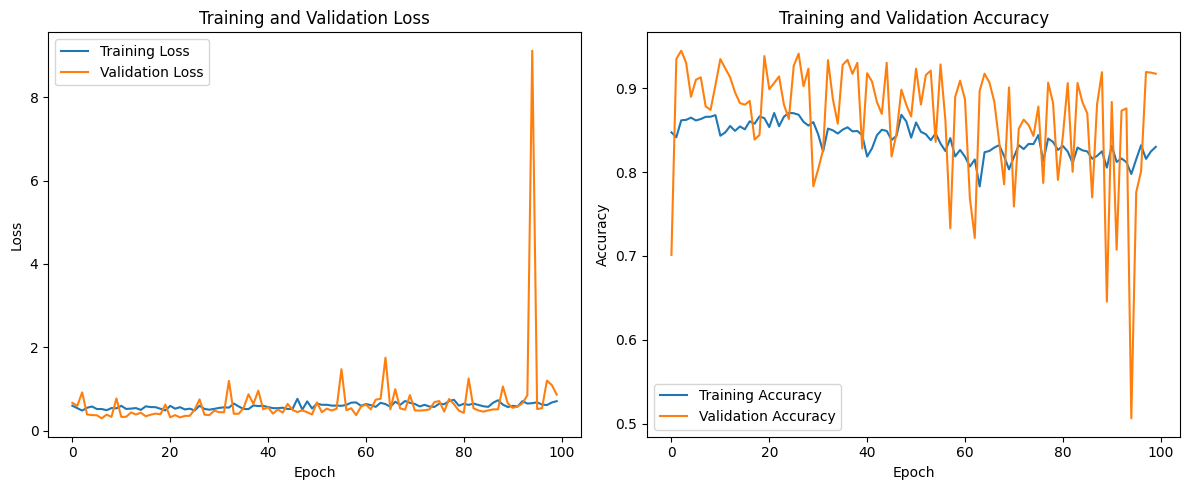

In [8]:
# Plot training loss and accuracy
for result in results:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(result.history['loss'], label='Training Loss')
    plt.plot(result.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(result.history['accuracy'], label='Training Accuracy')
    plt.plot(result.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [18]:
# Define size
batch_size = 16 # Batch size defines the number of samples that will be propagated through the network


# Configure augmentation for training adversity
# ImageDataGenerator rescales the pixels between zero and one
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# Set augmentation for testing
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Read pictures in 'data/train' directory and generate batches of image data with binary labels
train_generator = train_datagen.flow(
        X_train,  
        batch_size=batch_size,
        shuffle=False
        )  

# Same generator as above, but for validation data
validation_generator = test_datagen.flow(
        X_test,
        batch_size=batch_size,
        shuffle=False)

In [19]:
callback = EarlyStopping(
    monitor='val_acc', 
    restore_best_weights=True,
    patience=5
)

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split

# Load pre-trained VGG19 model without the top (fully connected) layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(50,50, 3))

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top
model = Sequential([
    base_model,
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification - malaria or not
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()
train_x, test_x, train_y, test_y = train_test_split(data, labels, test_size=0.8, random_state=111)
eval_x, test_x, eval_y, test_y = train_test_split(test_x, test_y, test_size=0.5, random_state=111)

history = model.fit(
        X_train,y_train,
        epochs=100, # num of epochs will dictate speed of model 
        validation_data=(X_test,y_test),
        )


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 502s 725ms/step - accuracy: 0.8722 - loss: 1.9163 - val_accuracy: 0.9176 - val_loss: 0.2159
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 464s 674ms/step - accuracy: 0.9210 - loss: 0.1995 - val_accuracy: 0.9203 - val_loss: 0.2135
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 464s 673ms/step - accuracy: 0.9289 - loss: 0.1824 - val_accuracy: 0.9222 - val_loss: 0.2072
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 444s 644ms/step - accuracy: 0.9330 - loss: 0.1680 - val_accuracy: 0.9182 - val_loss: 0.2296
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 444s 644ms/step - accuracy: 0.9403 - loss: 0.1620 - val_accuracy: 0.9236 - val_loss: 0.2174
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 439s 637ms/step - accuracy: 0.9381 - loss: 0.1619 - val_accuracy: 0.9193 - val_loss: 0.2190
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 439s 638ms/step - accuracy: 0.9413 - loss: 0.1484 - val_accuracy: 0.9194 - val_loss: 0.2362
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 444s 645ms/step - accuracy: 

KeyboardInterrupt: 

In [10]:
import shutil
import os
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf
import glob
import os
from PIL import Image
from PIL import ImageFilter
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import scikitplot as skplt
import matplotlib.pyplot as plt
from tensorflow import keras

from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.applications.vgg19 import VGG19
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score
#np.random.seed(123)
import itertools

In [18]:
# Load pre-trained VGG19 model without the top (fully connected) layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(50,50, 3))

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top
"""model = Sequential([
    base_model,
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification - malaria or not
])"""
print(base_model.output_shape)

model = Sequential()
model.add(base_model)
# Layer 1
model.add(Conv2D(None, (1, 1), input_shape=(None,1, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  

# Add 2 final dense layers to add a classifier to the convolutional base
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

(None, 1, 1, 512)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

None


In [3]:
import shutil
import os
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf
import glob
import os
from PIL import Image
from PIL import ImageFilter
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import scikitplot as skplt
import matplotlib.pyplot as plt
from tensorflow import keras

from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.applications.vgg19 import VGG19
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score
#np.random.seed(123)
import itertools
# Load pre-trained VGG19 model without the top (fully connected) layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(50,50, 3))

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top
"""model = Sequential([
    base_model,
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification - malaria or not
])"""
print(base_model.output_shape)
model = Sequential([
    base_model,
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification - malaria or not
])
"""
model = Sequential()
model.add(base_model)

# Layer 1
model.add(Conv2D(64, (3, 3),input_dim=reshape_y))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  

# Add 2 final dense layers to add a classifier to the convolutional base
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
"""
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())
infected_path = "/Users/fadiabaissi/Downloads/cell_images/Parasitized/"
uninfected_path = "/Users/fadiabaissi/Downloads/cell_images/Uninfected/"
infected_files = os.listdir(infected_path)
uninfected_files = os.listdir(uninfected_path)

# Define functions for data preprocessing
def preprocess_data(file_list, label):
    data = []
    labels = []
    for file in file_list:
        try:
            image = tf.keras.preprocessing.image.load_img(file, target_size=(50, 50))
            image_array = tf.keras.preprocessing.image.img_to_array(image)
            data.append(image_array)
            labels.append(label)
        except Exception as e:
            print(f"Error processing {file}: {e}")
    return data, labels

# Preprocess infected and uninfected data
infected_data, infected_labels = preprocess_data([os.path.join(infected_path, f) for f in infected_files], 1)
uninfected_data, uninfected_labels = preprocess_data([os.path.join(uninfected_path, f) for f in uninfected_files], 0)

# Combine data and labels
data = np.array(infected_data + uninfected_data)
labels = np.array(infected_labels + uninfected_labels)
print(len(data))

kFold=KFold(n_splits=5,shuffle=True)
results=[]
i=1
for train_index,test_index in kFold.split(data):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)
    
    X_train, X_test, y_train, y_test = data[train_index], data[test_index], labels[train_index], labels[test_index]
    result = model.fit(
        X_train,y_train,
        epochs=100, # num of epochs will dictate speed of model 
        validation_data=(X_test,y_test),
        )
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(result.history['loss'], label='Training Loss')
    plt.plot(result.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(result.history['accuracy'], label='Training Accuracy')
    plt.plot(result.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
    model.save("/Users/fadiabaissi/Downloads/results"+i+".keras")
    i+=1
    #results.append(result)
    

(None, 1, 1, 512)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

None
Error processing /Users/fadiabaissi/Downloads/cell_images/Parasitized/Thumbs.db: cannot identify image file <_io.BytesIO object at 0x3137e18a0>
Error processing /Users/fadiabaissi/Downloads/cell_images/Parasitized/.DS_Store: cannot identify image file <_io.BytesIO object at 0x3137e18a0>
Error processing /Users/fadiabaissi/Downloads/cell_images/Uninfected/Thumbs.db: cannot identify image file <_io.BytesIO object at 0x3137e18a0>
Error processing /Users/fadiabaissi/Downloads/cell_images/Uninfected/.DS_Store: cannot identify image file <_io.BytesIO object at 0x3137e18a0>
27558
Train Index:  [    0     1     2 ... 27553 27556 27557] 

Test Index:  [   14    15    16 ... 27549 27554 27555]
Epoch 1/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 395s 570ms/step - accuracy: 0.8695 - loss: 2.3033 - val_accuracy: 0.9142 - val_loss: 0.2196
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 552s 801ms/step - accuracy: 0.9219 - loss: 0.2032 - val_accuracy: 0.9253 - val_loss: 0.1998
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━

In [ ]:
i = 0
for res in results:
    print("===== Iteration", i, ": =====")
    print("Accuracy:", format(res.history['accuracy'][-1], ".2%"))
    print("Loss:", format(res.history['loss'][-1], ".2%"))
    i += 1